# Modeling (Part 1)

We will talk about:

1. Supervised learning, unsupervised learning
2. Regression, classification, clustering
3. Linear regression, Logistic regression, K-Means

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing, load_breast_cancer, load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, classification_report, confusion_matrix
)

np.random.seed(42) # this is used to make the results reproducible

# Supervised Learning

In supervised learning:

- We have data ($X$) and the correct answers (label $y$).
- The goal is to teach the model to use $X$ to predict $y$ for new examples.

There are two main types, and the difference is:

- **Regression**: Predict a number (e.g., house price)
- **Classification**: Predict a category (e.g., yes/no, red/blue)

## Linear Regression

### Mathematical Intuition

For single-variable linear regression:

$$\hat{y} = wx + b$$

We measure error with **Mean Squared Error (MSE)**:

$$\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y}_i)^2$$

Goal: find $w$ and $b$ that minimize MSE.

We will use the *California Housing* dataset from scikit-learn to perform linear regression

In [2]:
# Our demo uses a real-world dataset from scikit-learn: California Housing
housing = fetch_california_housing(as_frame=True)
X_housing = housing.data
y_housing = housing.target

print('Feature shape:', X_housing.shape)
print('Target shape:', y_housing.shape)
display(X_housing.head())
display(y_housing.head())

Feature shape: (20640, 8)
Target shape: (20640,)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [ ]:
# Single-feature version for visualization: use MedInc to predict house value
X_single = X_housing[['MedInc']]
y = y_housing

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    ...
)

linreg_single = ...
...
y_pred_s = ...

mse_s = mean_squared_error(y_test_s, y_pred_s)
r2_s = r2_score(y_test_s, y_pred_s)

print(f'Single-feature model: y_hat = {linreg_single.coef_[0]:.3f} * MedInc + {linreg_single.intercept_:.3f}')
print(f'MSE: {mse_s:.3f}')
print(f'R^2: {r2_s:.3f}')

Single-feature model: y_hat = 0.419 * MedInc + 0.445
MSE: 0.709
R^2: 0.459


### What is $R^2$?

$R^2$ (coefficient of determination) represents how well the model explains the variance in the target variable.

$R^2 = 0.459$ means that about 45.9% of the variation in house prices can be explained by the single feature MedInc (median income), while the remaining 54.1% of the variance is due to other factors or noise that the model does not capture.

Below we visualize the fitted regression line.

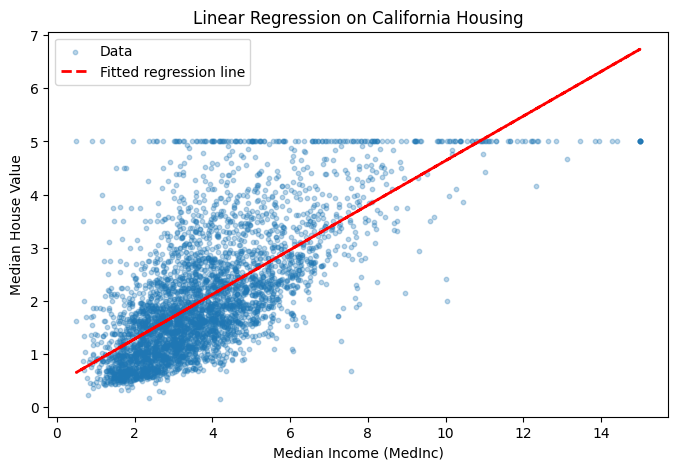

In [4]:
# Regression line visualization
plt.figure(figsize=(8, 5))
plt.scatter(X_test_s['MedInc'].values, y_test_s.values, alpha=0.3, s=10, label='Data')
plt.plot(X_test_s['MedInc'].values, y_pred_s, color='red', linewidth=2, linestyle='dashed', label='Fitted regression line')
plt.xlabel('Median Income (MedInc)')
plt.ylabel('Median House Value')
plt.title('Linear Regression on California Housing')
plt.legend()
plt.show()

In [ ]:
# Multi-feature linear regression using all available features
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_housing, y_housing, test_size=0.2, random_state=42
)

linreg_multi = LinearRegression()
linreg_multi.fit(X_train_m, y_train_m)
y_pred_m = linreg_multi.predict(X_test_m)

mse_m = ...
r2_m = ...

print(f'Multi-feature MSE:  {mse_m:.3f}')
print(f'Multi-feature R^2:  {r2_m:.3f}')

coef_table = pd.DataFrame({
    'feature': X_housing.columns,
    'coefficient': linreg_multi.coef_
}).sort_values('coefficient', ascending=False)

display(coef_table)

print(f'\nIntercept: {linreg_multi.intercept_:.6f}')

Multi-feature MSE:  0.556
Multi-feature R^2:  0.576


,feature,coefficient
3,AveBedrms,0.783145
0,MedInc,0.448675
1,HouseAge,0.009724
4,Population,-0.000002
5,AveOccup,-0.003526
2,AveRooms,-0.123323
6,Latitude,-0.419792
7,Longitude,-0.433708



Intercept: -37.023278


**Equation:**

$$
\hat{y} = -37.023278
+ 0.7831 \cdot \text{AveBedrms}
+ 0.4487 \cdot \text{MedInc}
+ 0.0097 \cdot \text{HouseAge}
$$
$$
- 0.000002 \cdot \text{Population}
- 0.0035 \cdot \text{AveOccup}
- 0.1233 \cdot \text{AveRooms}
$$
$$
- 0.4198 \cdot \text{Latitude}
- 0.4337 \cdot \text{Longitude}
$$

## Logistic Regression

### Mathematical Intuition

Logistic Regression fits a linear equation to the data, then squeezes the output through a **Sigmoid function** to produce a probability between 0 and 1, which is used to classify data into categories.

Let's visualize the sigmoid function first.

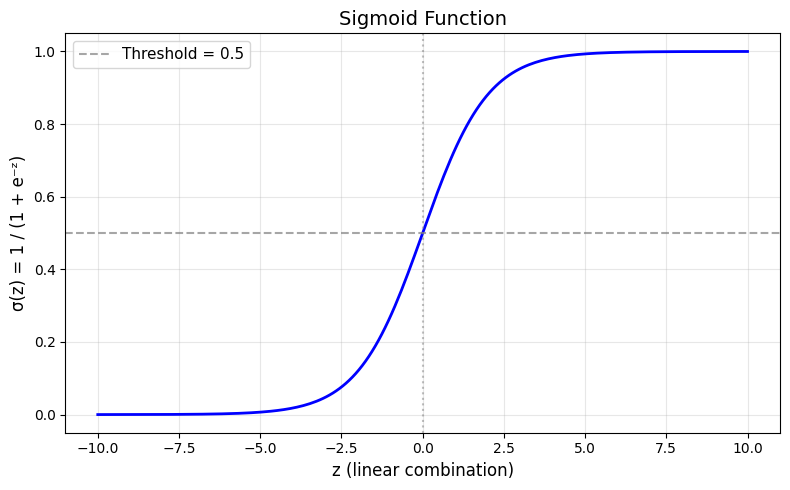

In [6]:
z = np.linspace(-10, 10, 200)
sigmoid = 1 / (1 + np.exp(-z))

plt.figure(figsize=(8, 5))
plt.plot(z, sigmoid, color='blue', linewidth=2)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Threshold = 0.5')
plt.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
plt.xlabel('z (linear combination)', fontsize=12)
plt.ylabel('σ(z) = 1 / (1 + e⁻ᶻ)', fontsize=12)
plt.title('Sigmoid Function', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Next, we will perform logistic regression on the *Breast Cancer Wisconsin* dataset from scikit-learn.

In [7]:
# Real-world dataset from scikit-learn: Breast Cancer Wisconsin
cancer = load_breast_cancer(as_frame=True)
X_cancer = cancer.data
y_cancer = cancer.target
print('Classes:', cancer.target_names)
print()
print('Shape:', X_cancer.shape)
print()
print(y_cancer.value_counts())
print()
display(X_cancer.head())

Classes: ['malignant' 'benign']

Shape: (569, 30)

target
1    357
0    212
Name: count, dtype: int64



,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=y_cancer
)

# Standardize features because logistic regression is scale-sensitive
scaler = ...
X_train_c_scaled = ...
X_test_c_scaled = ...

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_c_scaled, y_train_c)
y_pred_c = logreg.predict(X_test_c_scaled)

acc = accuracy_score(y_test_c, y_pred_c)
print(f'Accuracy: {acc:.4f}')
print()
print('Classification report:')
print(classification_report(y_test_c, y_pred_c, target_names=cancer.target_names))

Accuracy: 0.9825

Classification report:
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



### What are these evaluation metrics?
- Accuracy: The percentage of all predictions that the model got right.
- Precision: Out of everything the model predicted as positive, how many were actually positive. (How trustworthy are the "yes" predictions?)
- Recall: Out of all the actual positives, how many did the model successfully catch. (How good is the model at finding all the real positives?)
- F1-score: A single number that balances Precision and Recall — useful when you care about both equally.
- Support: Simply the number of actual samples in each class — it's not a metric, just a count telling you how many real examples of each class exist in the test data.

**Confusion matrix** is also a good visualization plot to see the performence of a binary classification task, including all the metrics above, implicitly.

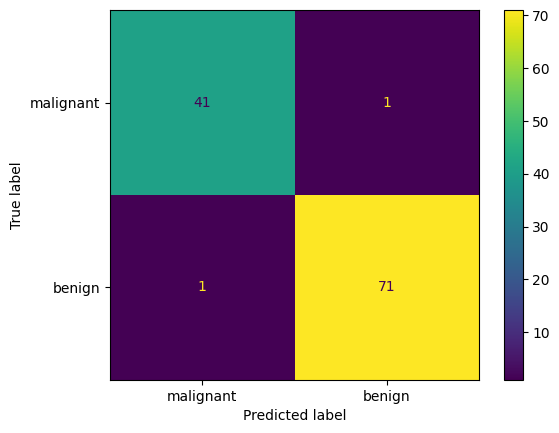

In [ ]:
cm = ...

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test_c, y_pred_c, display_labels=cancer.target_names)

# Unsupervised Learning

Unsupervised learning means:

- We only have input features $X$ and no labels $y$.
- We want to discover hidden structure in data.

## K-Means Clustering

Algorithm intuition:

1. Initialize $K$ centroids
2. Assign each point to its nearest centroid
3. Update centroids as cluster means
4. Repeat steps 2-3 until convergence

In [10]:
##### YOU DON"T NEED TO UNDERSTAND THIS CODE, IT IS JUST FOR ILLUSTRATION #####



import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

np.random.seed(11111)
X = np.vstack([
    np.random.randn(50, 2) + [2, 2],
    np.random.randn(50, 2) + [-2, -2],
    np.random.randn(50, 2) + [2, -2]
])

k = 3
centroids = X[np.random.choice(len(X), k, replace=False)]

history_centroids = [centroids.copy()]
history_labels = []

for _ in range(10):
    distances = np.linalg.norm(X[:, None] - centroids[None, :], axis=2)
    labels = np.argmin(distances, axis=1)
    history_labels.append(labels.copy())

    new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
    if np.allclose(centroids, new_centroids):
        break
    centroids = new_centroids
    history_centroids.append(centroids.copy())

colors = ['#e74c3c', '#3498db', '#2ecc71']
fig, ax = plt.subplots(figsize=(8, 6))

def animate(frame):
    ax.clear()
    step = frame // 2
    phase = frame % 2

    if step < len(history_labels):
        labels = history_labels[step]
        for i in range(k):
            ax.scatter(X[labels == i, 0], X[labels == i, 1],
                       c=colors[i], alpha=0.5, s=30)

        if phase == 0:
            c = history_centroids[step]
            ax.set_title(f'Step {step + 1}: Assign points to nearest centroid', fontsize=13)
        else:
            c = history_centroids[min(step + 1, len(history_centroids) - 1)]
            ax.set_title(f'Step {step + 1}: Update centroids', fontsize=13)

        ax.scatter(c[:, 0], c[:, 1], c='black', marker='X', s=200,
                   edgecolors='white', linewidths=2, zorder=5)

    ax.set_xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    ax.set_ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

total_frames = len(history_labels) * 2
anim = FuncAnimation(fig, animate, frames=total_frames, interval=800, repeat=True)
plt.close(fig)
HTML(anim.to_jshtml())

We will use the *Iris* dataset from scikit-learn, to perform K-Means clustering.

In [11]:
# Real-world dataset from scikit-learn: Iris
iris = load_iris(as_frame=True)
X_iris_full = iris.data
y_iris_true = iris.target

# We use two features for simple 2D visualization
X_iris = X_iris_full[['petal length (cm)', 'petal width (cm)']]
X_iris

,petal length (cm),petal width (cm)
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2
...,...,...
145,5.2,2.3
146,5.0,1.9
147,5.2,2.0
148,5.4,2.3


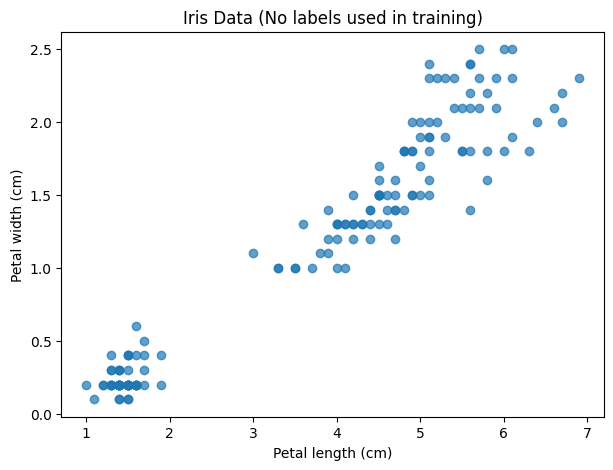

In [12]:
plt.figure(figsize=(7, 5))
plt.scatter(X_iris.iloc[:, 0], X_iris.iloc[:, 1], alpha=0.7)
plt.xlabel('Petal length (cm)')
plt.ylabel('Petal width (cm)')
plt.title('Iris Data (No labels used in training)')
plt.show()

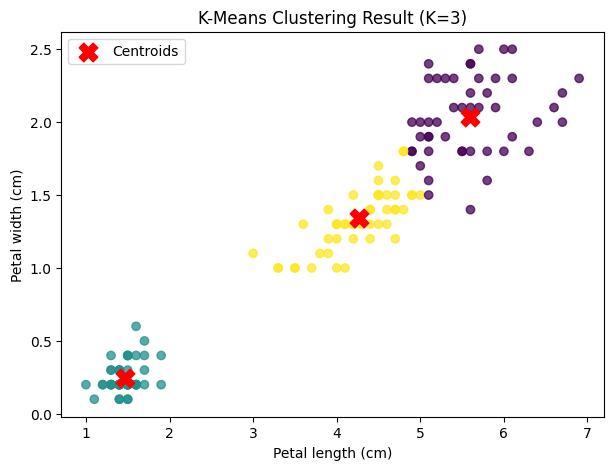

In [ ]:
# Choose K=3 (a common choice for Iris)
kmeans = ... # here you can also try different values of K
cluster_labels = ...
centers = ...

plt.figure(figsize=(7, 5))
plt.scatter(X_iris.iloc[:, 0], X_iris.iloc[:, 1], c=cluster_labels, cmap='viridis', alpha=0.75)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=180, marker='X', label='Centroids')
plt.xlabel('Petal length (cm)')
plt.ylabel('Petal width (cm)')
plt.title('K-Means Clustering Result (K=3)')
plt.legend()
plt.show()

Key takeaways:

1. Supervised learning uses labeled data and includes regression/classification tasks
2. Linear regression predicts continuous values; logistic regression predicts which class a data point belongs to
3. Unsupervised learning discovers structure without labels, and K-Means is a classic clustering method